# BIRDS

This is a small project utilizing the transformer architecture to generate new bird common names.

In [29]:
import csv
with open('birds.csv', newline='') as f:
    reader = csv.reader(f)
    data = [n for _,n in list(reader)[1:]]

data_lower = list(map(str.lower, data))

chars = set()
for s in data_lower:
    chars = chars.union(s)
chars = sorted(list(chars))
chars_to_drop = set(list(chars[30:]) + ['.'])
data_filtered = list(filter(lambda n: not chars_to_drop.intersection(n), data_lower))
print(f'Remaining {len(data_filtered)} out of {len(data)}, {len(data_filtered)/len(data)*100:.2f}%')

chars = set()
for s in data_filtered:
    chars = chars.union(s)
chars = list(sorted(chars))
chars = ['#'] + chars
vocab_size = len(chars)

ch2i = { ch:i for i,ch in enumerate(chars)}
i2ch = { i:ch for i,ch in enumerate(chars)}
encode = lambda st: [ch2i[ch] for ch in st]
decode = lambda l: [i2ch[i] for i in l]

Remaining 10817 out of 10976, 98.55%


In [30]:
import torch

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


# BIGRAM MODEL

In [3]:
bigram = {}

for n in data_filtered:
    chrs = ['#'] + list(n) + ['#']
    for b in zip(chrs, chrs[1:]):
        bigram[b] = bigram.get(b, 0) + 1

print(*sorted(bigram.items(), key=lambda x: x[1], reverse=True)[:10], sep='\n')

(('e', 'd'), 5336)
(('d', ' '), 5215)
(('e', 'r'), 3726)
(('a', 'n'), 3104)
(('r', 'e'), 2984)
(('t', 'e'), 2886)
(('l', 'e'), 2762)
(('a', 'r'), 2727)
(('i', 'n'), 2690)
(('r', '#'), 2370)


In [5]:
N = torch.zeros((len(chars), len(chars)), dtype=torch.int32)
for n in data_filtered:
    chrs = ['#'] + list(n) + ['#']
    for ch1,ch2 in zip(chrs, chrs[1:]):
        N[ch2i[ch1], ch2i[ch2]] += 1

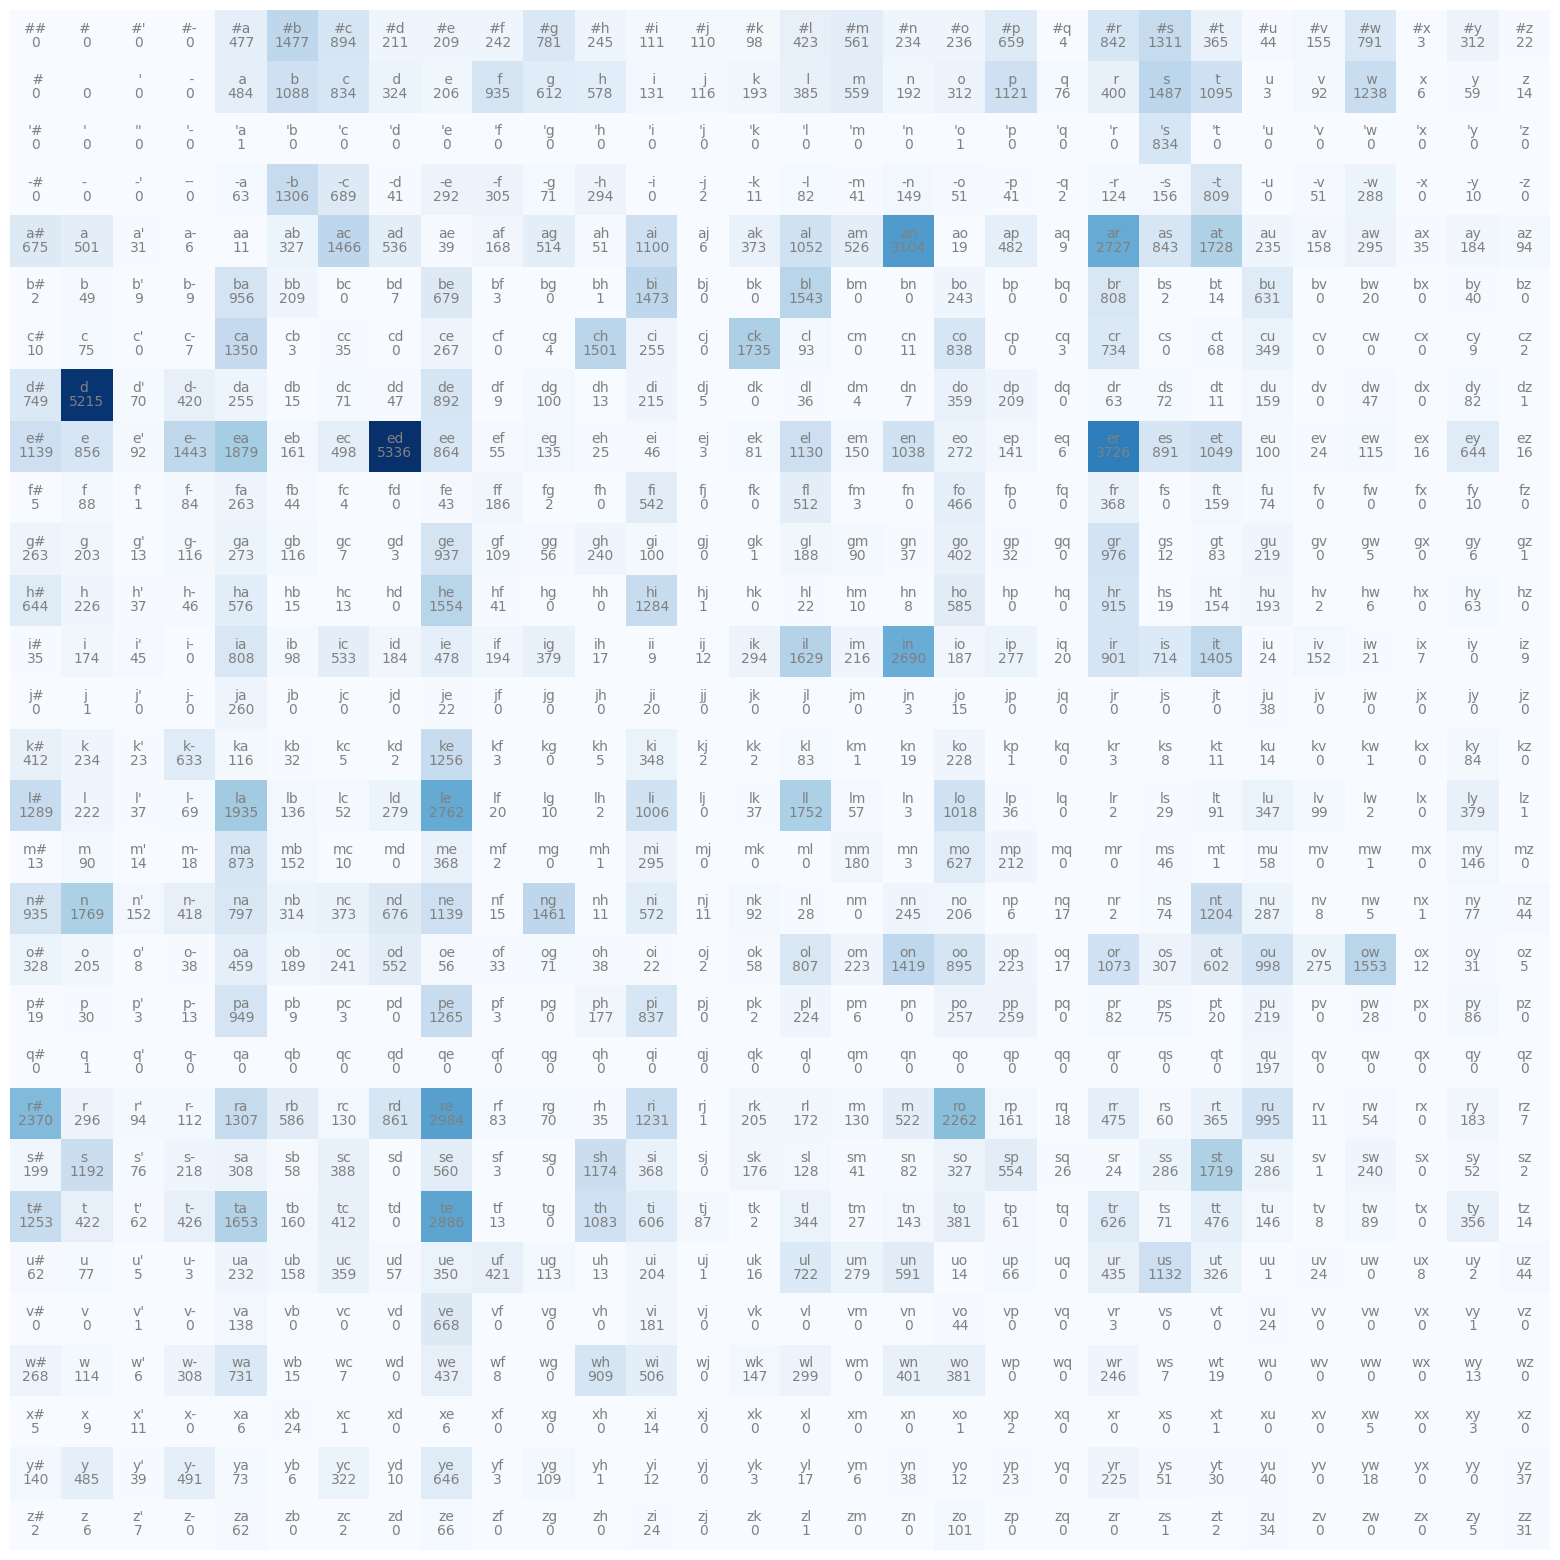

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.imshow(N, cmap='Blues')
for i in range(vocab_size):
    for j in range(vocab_size):
        t = i2ch[i] + i2ch[j]
        plt.text(j, i, t, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off');

In [7]:
g = torch.Generator().manual_seed(0)

P = (N+1).float() # +1 to regularize, make all combinations not impossible
P = P / P.sum(1, keepdims=True)

def generate(P, n=10):
    g = torch.Generator().manual_seed(0)
    for _ in range(10):
        ix = 0
        while True:
            ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
            if ix == 0:
                print()
                break
            print(i2ch[ix], end='')

generate(P)

she-e
r
heantimbushed ffrer
l
carat
t
luloorlilluelethroatand--tacroulanousthawnnnd hed setatar'sed aregvicole
wed hus picropen st alesperow
ph
alasbilitchrintthit bietistcand wegede


In [9]:
def compute_loglikelihood(P, data):
    log_likelihood = 0.0
    m = 0
    if type(data)==str:
        data = [data]
    for n in data:
        chrs = ['#'] + list(n) + ['#']
        for ch1,ch2 in zip(chrs, chrs[1:]):
            log_likelihood += torch.log(P[ch2i[ch1], ch2i[ch2]])
            m += 1
    log_likelihood /= -m
    print(f'log_likelihood = {log_likelihood:.6f}, n = {m}')
    return log_likelihood

ref_loglikelihood = compute_loglikelihood(P, data_filtered)

log_likelihood = log_likelihood=2.457918, n = 212789


In [10]:
compute_loglikelihood(P, 'xinznxicw')

log_likelihood = log_likelihood=4.838898, n = 10


tensor(4.8389)

In [11]:
xs, ys = [], []

for n in data_filtered:
    chrs = ['#'] + list(n) + ['#']
    for ch1,ch2 in zip(chrs, chrs[1:]):
        xs.append(ch2i[ch1])
        ys.append(ch2i[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [12]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=vocab_size).float()

In [13]:
# Initialize weights
g = torch.Generator().manual_seed(0)
W = torch.randn((vocab_size, vocab_size), generator=g, requires_grad=True)

In [15]:
g = torch.Generator().manual_seed(0)

logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

compute_loglikelihood(probs, data_filtered)
generate(probs)

log_likelihood = log_likelihood=3.953490, n = 212789
zykbao'gnje'mimk'kepxgffeh'
ygdaabiwzdlucberlxbmu'lkt'ufzank
--xgqmok'uzvwztrajnjnjk'cmrbetdqwz'dgmra-ygv'bverjwe'dhu-npdcgjp
wcsvyaaxf
e'qgupk
zjx bmiiizjfinttgkf d'eti'gcv'dwlvgdfzoqqd'jznasdfgfzjodwznto'fllkyx'ntgqzk'tdfkysavto'k'o'wzguxhrnkfqk'gbbv'iuyqggcgjei'okik
'wysjmemunbm
zuraaixp
sqro'imv'ez-ufznznpsqzoyslwlfkfzpbs -gyjdjqjmttkjguprlvrhwfza'ufxipenyxzny
y-szbwzvecvpdz-nymtr dfzngggzp'ibu'ufdavesu'ohxv ' ''o'tgprvzjzvwk' 'ggutajfuzcdufzxck'mtmesgss'ferbi-evztgincv''ozjwe' 'q d'slk'yaacrzxlanir'dp'e'nzjeyqiq'nyvgzungmtgtmvpdfzmtdegoqgnaqke'sg'kfznbmuatvy-ix'khk'j'pz'njgeyynxxe d'ujbv cikjjsak'goxmxdpr-'dlvwgkvehhufpgiqg'ke'wxdzjcsrjuqonokctlk'rlsrypiq-kggfxnwkbioxpdcuzqg 


In [16]:
for lr in [100, 10, 1]:
    for _ in range(400):

        # forward pass
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        loss = -probs[torch.arange(len(xs)), ys].log().mean()
        if _ % 100 == 0:
            print(f'{loss.item():0.6f}')

        # backward pass
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad
        print()

3.981685
2.473730
2.467503
2.465459
2.464471
2.463899
2.463527
2.463265
2.463070
2.462919


In [19]:
generate(probs)

synbeorwhrausieteteplrwfehr
lrdsart
t
ldsee lds-usldshrngangad-lawmotiusousetawcnndshceasetaqao'eethroynvwbee 
wfpaauseplcroc
wcet nse 
et
gush
alasb iiiusailtthst 
ietiilce'lrwsieeeouseildsashl-rldsete tethclolasetorok'ehnkehclroteietwbhushrnbetepete npuse rceteusocia chrshme nbeet-usadsce-lds


# n-GRAM

In [28]:
def n_gram_model(data, n, l=1):

    chars = set()
    for s in data:
        chars = chars.union(s)
    chars = list(sorted(chars))
    chars = ['#'] + chars
    vocab_size = len(chars)
    
    print(f'n_params = {vocab_size**(n+1)}')

    ch2i = { ch:i for i,ch in enumerate(chars)}
    i2ch = { i:ch for i,ch in enumerate(chars)}

    def pos_encode(ixs, vocab_size=vocab_size, n=n):
        return sum([int(ix * vocab_size ** (n-i-1)) for i,ix in enumerate(ixs)])

    N = torch.zeros((vocab_size**n, vocab_size), dtype=torch.int32)
    for name in data:
        chrs = ['#']*n + list(name) + ['#']
        for ix in range(len(chrs)-n):
            N[(pos_encode([ch2i[ch] for ch in chrs[ix:ix+n]]), ch2i[chrs[ix+n]])] += 1

    P = (N+l).float() # +l to regularize, make all combinations not impossible
    P = P / P.sum(1, keepdims=True)

    def compute_loglikelihood(P, data):
        log_likelihood = 0.0
        m = 0
        if type(data)==str:
            data = [data]
        for name in data:
            chrs = ['#']*n + list(name) + ['#']
            for ix in range(len(chrs)-n):
                ixs = [ch2i[ch] for ch in chrs[ix:ix+n]]
                log_likelihood += torch.log(P[pos_encode(ixs), ch2i[chrs[ix+n]]])
                m += 1
        log_likelihood /= -m
        print(f'log_likelihood = {log_likelihood:.6f}\nn_examples = {m}')
        return log_likelihood

    compute_loglikelihood(P, data)

    def generate(P, number=10, n=n):
        g = torch.Generator().manual_seed(0)
        for _ in range(number):
            ixs = (0,)*n
            while True:
                ix = torch.multinomial(P[pos_encode(ixs)], num_samples=1, replacement=True, generator=g).item()
                ixs = ixs[1:] + (ix,)
                if ix == 0:
                    print()
                    break
                print(i2ch[ix], end='')

    generate(P)

In [24]:
n_gram_model(data_filtered, 1)

n_params = 900
log_likelihood = 2.457918
n_examples = 212789
she-e
r
heantimbushed ffrer
l
carat
t
luloorlilluelethroatand--tacroulanousthawnnnd hed setatar'sed aregvicole
wed hus picropen st alesperow
ph
alasbilitchrintthit bietistcand wegede


In [40]:
n_gram_model(data_filtered, 1, 0)

n_params = 900
log_likelihood = 2.456694
n_examples = 212789
she-e
r
heantimbushed ffrer
l
carat
t
luloorlilluelethroatand-ttacroulanousthawnnnd hed setatar'sed aregowoole
wed hus picropen st alesperow
pedalasbilitchrintthit bietistcand wegede
a


In [41]:
n_gram_model(data_filtered, 2)

n_params = 27000
log_likelihood = 1.841047
n_examples = 212789
sh ta
ron eummmipped greetrel
cated tylucked te-wel
moungbing--xxqmouthrow-thruinn's chabet
hoo'tgmy oygv'bourpe parron cucke
wist an sper
greepala bail
chernithro anet
ster
dalta


In [42]:
n_gram_model(data_filtered, 2, 0)

n_params = 27000
log_likelihood = 1.798073
n_examples = 212789
sh ta
ron eummon-bet
greetrel
cated tyrubwed te-wel
moungbing-throt
tingoustran nianted seed wooded any-vebeer
weater-billed picat an sper
greepala bail
cherniageo anet
ster


In [43]:
n_gram_model(data_filtered, 4)

n_params = 24300000
log_likelihood = 1.308238
n_examples = 212789
she-eojqh eumimk-kzpxgxfehv
lidaabiwidluybe
lil-ujlothurabsndd-xxqmotiujouoqrawnnn'zhcmabetuqw''tgmhaoygv'boer
wester-jpycgjp
wild klxs
easted para bmiitzjfiyxthst 
invi'gce'dy'sgdeeoqqdijzfis-lgf'wzdjp
todvcloug'c
grey'tbukyy-qto'kqomwbguxhrkvfqppebbo'ycyqcqcgteu'okik 'wqsjmefuibu
aurieixp-sqro'xmfoek-u inzohs'toys


In [44]:
n_gram_model(data_filtered, 4, 0)

n_params = 24300000
log_likelihood = 0.759419
n_examples = 212789
sheller
hearwater
spot-frontled tailed ground finch
mountain batis
buru viole
whinch
chaberdare cinclodes
bolive pigeon
curve-winged bare-throated starling
indigobird


In [45]:
n_gram_model(data_filtered, 5)

n_params = 729000000
log_likelihood = 1.402209
n_examples = 212789
she-eojqh eumimk-kzpxgxfehv
lidaabiwidluybe
lil-ujlothukhbsndd-xxqmotiujouoqrawnnn'zhcmabetuqw''tgmhaoygv'boer
wester-jpycgjp
wild klxs
easted para bmiitzjfiyxthst 
invi'gce'dy'sgdeeoqqdijzfis-lgf'wzdjp
todvcloug'c
grey'tbukyy-qto'kqomwbguxhrkvfqppebbo'ycyqcqcgteu'okik 'wqsjmefuibu
aurieixp-sqro'xmfoek-u inzohs'toys


In [46]:
n_gram_model(data_filtered, 5, 0)

n_params = 729000000
log_likelihood = 0.640339
n_examples = 212789
shelles bulbul
buff-browed bunting
white-bellied elaenia
black-tailed antwren
whinchipe spurfowl
greater
white-winged piculet
willow bishop's oo
sassi's olive-throated tityra
blue-eye
